<a href="https://colab.research.google.com/github/flora0110/DBMS-Final-Project/blob/master/%E3%80%8C%E3%80%8Cpodcast_to_headline_del_spon_history_complete.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Textsplit

In [1]:
!pip install word2vec

     |████████████████████████████████| 42 kB 357 kB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for word2vec: filename=word2vec-0.11.1-py2.py3-none-any.whl size=156420 sha256=5310f189435737e8d925f9eab7445644bfc6e20c4709d89cd644a2b780c12b08
  Stored in directory: /root/.cache/pip/wheels/c9/c0/d4/29d797817e268124a32b6cf8beb8b8fe87b86f099d5a049e61
Successfully built word2vec


In [2]:
import os
from gensim.models import word2vec
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

## Download toy corpus for wordvector training and example text

In [3]:
corpus_path = './text8'  # be sure your corpus is cleaned from punctuation and lowercased
if not os.path.exists(corpus_path):
    !wget http://mattmahoney.net/dc/text8.zip
    !unzip {corpus_path}

--2022-05-15 15:01:05--  http://mattmahoney.net/dc/text8.zip
Resolving mattmahoney.net (mattmahoney.net)... 67.195.197.24
Connecting to mattmahoney.net (mattmahoney.net)|67.195.197.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31344016 (30M) [application/zip]
Saving to: ‘text8.zip’

text8.zip           100%[===================>]  29.89M  2.15MB/s    in 14s     

2022-05-15 15:01:19 (2.16 MB/s) - ‘text8.zip’ saved [31344016/31344016]

Archive:  ./text8.zip
  inflating: text8                   


In [4]:
links = {'podcast_text': 'https://raw.githubusercontent.com/grace-boop/podcast/main/flora_darkhistory'}  # siddartha

for link in links.values():
    text_path = os.path.basename(link)
    if not os.path.exists(text_path):
        !wget {link}

--2022-05-15 15:01:21--  https://raw.githubusercontent.com/grace-boop/podcast/main/flora_darkhistory
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41597 (41K) [text/plain]
Saving to: ‘flora_darkhistory’

flora_darkhistory   100%[===================>]  40.62K  --.-KB/s    in 0.003s  

2022-05-15 15:01:21 (12.5 MB/s) - ‘flora_darkhistory’ saved [41597/41597]



## Train wordvectors

In [5]:
import logging
wrdvec_path = 'wrdvecs.bin'
if not os.path.exists(wrdvec_path):
  sentences = word2vec.Text8Corpus('./text8')
  model = word2vec.Word2Vec(sentences, cbow_mean=1, iter=5, hs=1, sample=0.00001, window=15, size=200)

In [6]:
model.save(wrdvec_path)

In [7]:
model = word2vec.Word2Vec.load(wrdvec_path)
wrdvecs = pd.DataFrame(model.wv.vectors, index=model.wv.vocab)

## get sentence tokenizer

In [8]:
!pip install textsplit

     |████████████████████████████████| 154 kB 5.2 MB/s 


In [9]:
from textsplit.tools import SimpleSentenceTokenizer
sentence_tokenizer = SimpleSentenceTokenizer()

## run get_penalty and split_optimal

In [10]:
%matplotlib inline
from textsplit.tools import get_penalty, get_segments
from textsplit.algorithm import split_optimal, split_greedy, get_total

### podcast

In [11]:
#@title segment target length in sentences { display-mode: "form" }
segment_len =  25#@param {type:"integer"}

47.91044966587482
penalty 49.13
632 sentences, 21 segments, avg 30.10 sentences per segment
optimal score 14418.89, greedy score 14364.86
[14418.893040678537, 14364.859089408003]
(14418.893040678537, 14364.859089408003)
ratio of scores 1.0038


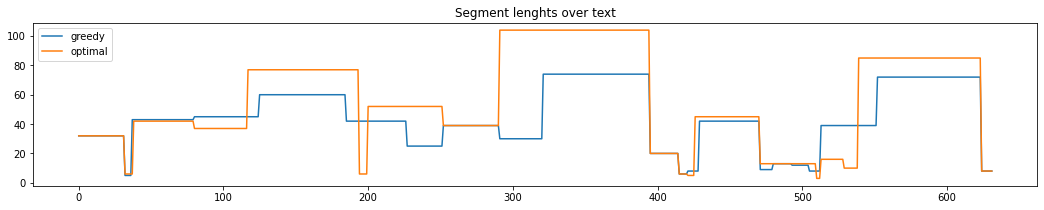

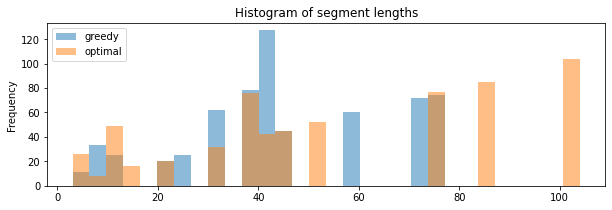

In [12]:
link = links['podcast_text']
book_path = os.path.basename(link)

with open(book_path, 'rt') as f:
    text = f.read()  #.replace('\n', ' ')  # punkt tokenizer handles newlines not so nice

sentenced_text = sentence_tokenizer(text)
strs = " "
for i in range(len(sentenced_text)):
  if(sentenced_text[i] != " "):
    strs =sentenced_text[i]
  if(i+1<len(sentenced_text)):
    if(strs == sentenced_text[i+1]):
      sentenced_text[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(sentenced_text).dot(wrdvecs)
new_length = len(sentenced_text)**0.6
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
#penalty = get_penalty([sentence_vectors], segment_len)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(sentenced_text, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(sentenced_text), len(segmented_text), len(sentenced_text) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(sentenced_text, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

#### 顯示分段

In [13]:
for i in range(len(segmented_text)):
  print(segmented_text[i])
  

['Hi friends. ', "Happy Wednesday or Thursday if you're watching over on YouTube. ", 'Hey, how are you doing? ', "I hope you're having a wonderful day so far. ", 'My name is Bailey. ', 'Sarian. ', 'And this is the dark History podcast on your team song for dark history. ', "Don't I anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that I never learned in school if you're new here. ", 'Hi, welcome, take a seat by me. ', "Don't be shy. ", "If you're interested in learning about people and events that your history books in a covering school and maybe should have then you'll fit in right in here with us. ", 'Ok luck today, story. ', "It's uncomfortable. ", "Okay, it's heartbreaking. ", "It's it's just, it's it's awful. ", "It's that there's, those are all the words I can think of it, just doesn't make any sense. ", "But with all of that being said, there's really like, no sugar-coating this, this is what happened and it's when we

In [14]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.').rstrip('?'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))
print(first_sentence)
1

Hi friends. 
<class 'str'>
32
For all of that, on the morning of January 1st, 1923 30 year old James, and his 22-year old wife, Fannie, Taylor woke up at a home, and a town called Sumner, a neighboring community of Rosewood. 
<class 'str'>
6
I know because it is. 
<class 'str'>
42
Now, it's a Rosewood. 
<class 'str'>
37
Today's episode January, 1st. 
<class 'str'>
77
I freaking roll-rite, it gets a lot more traumatic talking amongst the name comes up, Jesse Hunter, and they think they're discussing are like, Hey, Jessie Hunter, this is our guy. 
<class 'str'>
6
He must have done. 
<class 'str'>
52
This is just the tip of the iceberg. 
<class 'str'>
39
So the black community is terrified by what they're seeing happening in their own town of Rosewood. 
<class 'str'>
104
Those who could they ran for the swamp? 
<class 'str'>
20
By this time, word got out about what was going on in roast. 
<class 'str'>
6
Okay. 
<class 'str'>
5
Again and a new city. 
<class 'str'>
45
Push back to Stop blac

1

In [15]:
print(sentenced_text)

['Hi friends. ', "Happy Wednesday or Thursday if you're watching over on YouTube. ", 'Hey, how are you doing? ', "I hope you're having a wonderful day so far. ", 'My name is Bailey. ', 'Sarian. ', 'And this is the dark History podcast on your team song for dark history. ', "Don't I anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that I never learned in school if you're new here. ", 'Hi, welcome, take a seat by me. ', "Don't be shy. ", "If you're interested in learning about people and events that your history books in a covering school and maybe should have then you'll fit in right in here with us. ", 'Ok luck today, story. ', "It's uncomfortable. ", "Okay, it's heartbreaking. ", "It's it's just, it's it's awful. ", "It's that there's, those are all the words I can think of it, just doesn't make any sense. ", "But with all of that being said, there's really like, no sugar-coating this, this is what happened and it's when we

### 處理輸入

In [16]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [17]:
print(podcast_test)

["Hi friends. Happy Wednesday or Thursday if you're watching over on YouTube. Hey, how are you doing? I hope you're having a wonderful day so far. My name is Bailey. Sarian. And this is the dark History podcast on your team song for dark history. Don't I anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that I never learned in school if you're new here. Hi, welcome, take a seat by me. Don't be shy. If you're interested in learning about people and events that your history books in a covering school and maybe should have then you'll fit in right in here with us. Ok luck today, story. It's uncomfortable. Okay, it's heartbreaking. It's it's just, it's it's awful. It's that there's, those are all the words I can think of it, just doesn't make any sense. But with all of that being said, there's really like, no sugar-coating this, this is what happened and it's when were honest and when were transparent that we can learn and grow t

# Headline generator

In [18]:
! pip install transformers datasets

     |████████████████████████████████| 4.2 MB 5.3 MB/s 
     |████████████████████████████████| 342 kB 39.9 MB/s 
     |████████████████████████████████| 6.6 MB 38.3 MB/s 
     |████████████████████████████████| 84 kB 3.5 MB/s 
     |████████████████████████████████| 596 kB 27.3 MB/s 
     |████████████████████████████████| 136 kB 58.9 MB/s 
     |████████████████████████████████| 212 kB 43.3 MB/s 
     |████████████████████████████████| 1.1 MB 9.0 MB/s 
     |████████████████████████████████| 127 kB 54.0 MB/s 
     |████████████████████████████████| 94 kB 2.4 MB/s 
     |████████████████████████████████| 271 kB 51.7 MB/s 
     |████████████████████████████████| 144 kB 40.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ER

In [19]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 4.9 MB/s 


In [20]:
from transformers import pipeline

## 使用Michau/t5-base-en-generate-headline

In [21]:
headlineGenerator = pipeline(model="Michau/t5-base-en-generate-headline", tokenizer="Michau/t5-base-en-generate-headline")

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.74k [00:00<?, ?B/s]

In [22]:
#@title 生成標題的長度 { display-mode: "form" }
min_length =  5#@param {type:"integer"}
max_length = 150#@param {type:"integer"}

In [23]:
headlines = headlineGenerator(podcast_test, min_length, max_length)


Ignoring args : (5, 150)
Token indices sequence length is longer than the specified maximum sequence length for this model (610 > 512). Running this sequence through the model will result in indexing errors


### 顯示結果

In [24]:
for headline in headlines:
  print(headline)
  print(type(headline))

{'generated_text': 'Dark History Podcast - A Dark History Podcast'}
<class 'dict'>
{'generated_text': 'Rosewood, Florida - A Story of a Hero'}
<class 'dict'>
{'generated_text': 'The Rosewood Massacre'}
<class 'dict'>
{'generated_text': 'Best Fiends - A Puzzle Game For Your Noggin'}
<class 'dict'>
{'generated_text': 'The Black Man Attacks Fanny'}
<class 'dict'>
{'generated_text': 'Jesse Hunter, This is Our Guy.'}
<class 'dict'>
{'generated_text': 'The Black Man That Attacked Fanny'}
<class 'dict'>
{'generated_text': 'Hello Fresh - The Best Meal Kits For the Dark History Posse'}
<class 'dict'>
{'generated_text': 'The Rosewood Massacre'}
<class 'dict'>
{'generated_text': 'The Mob Shot Mingo Williams'}
<class 'dict'>
{'generated_text': "What's a lot of names and Throwing at you?"}
<class 'dict'>
{'generated_text': 'The Rosewood Train Station'}
<class 'dict'>
{'generated_text': 'Squarespace - The Perfect Platform For Your Brand'}
<class 'dict'>
{'generated_text': 'The Rosewood Massacre - No

In [25]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['Dark History Podcast', '-', 'A Dark History Podcast']
['Dark History Podcast', '-', 'A Dark History Podcast']
<class 'str'>
['Rosewood', ',', 'Florida', '-', 'A Story of a Hero']
['Rosewood', ',', 'Florida', '-', 'A Story of a Hero']
<class 'str'>
['The Rosewood Massacre']
['The Rosewood Massacre']
<class 'str'>
['Best Fiends', '-', 'A Puzzle Game For Your Noggin']
['Best Fiends', '-', 'A Puzzle Game For Your Noggin']
<class 'str'>
['The Black Man Attacks Fanny']
['The Black Man Attacks Fanny']
<class 'str'>
['Jesse Hunter', ',', 'This is Our Guy', '.', '']
['Jesse Hunter', ',', 'This is Our Guy', '.', '']
<class 'str'>
['The Black Man That Attacked Fanny']
['The Black Man That Attacked Fanny']
<class 'str'>
['Hello Fresh', '-', 'The Best Meal Kits For the Dark History Posse']
['Hello Fresh', '-', 'The Best Meal Kits For the Dark History Posse']
<class 'str'>
['The Rosewood Massacre']
['The Rosewood Massacre']
<class 'str'>
['The Mob Shot Mingo Williams']
['The Mob Shot Mingo William

In [26]:
for headline_string in headlines_string:
  print(headline_string)

 Dark History Podcast - A Dark History Podcast
 Rosewood , Florida - A Story of a Hero
 The Rosewood Massacre
 Best Fiends - A Puzzle Game For Your Noggin
 The Black Man Attacks Fanny
 Jesse Hunter , This is Our Guy . 
 The Black Man That Attacked Fanny
 Hello Fresh - The Best Meal Kits For the Dark History Posse
 The Rosewood Massacre
 The Mob Shot Mingo Williams
 What's a lot of names and Throwing at you?
 The Rosewood Train Station
 Squarespace - The Perfect Platform For Your Brand
 The Rosewood Massacre - No Records
 The Little Things in Life Are Smiling At Your Neighbor
 Stamps . com - The Best Way to Save Money and Time
 Rosewood , the survivors are living in constant fear
 The Black Community , Not Forgiving
 Rosewood Millionaires , You Know
 The Rosewood Massacre - A History of the Tulsa Race Massacre
 Dark History - Part 2


In [27]:
print(headlines_string)
1

[' Dark History Podcast - A Dark History Podcast', ' Rosewood , Florida - A Story of a Hero', ' The Rosewood Massacre', ' Best Fiends - A Puzzle Game For Your Noggin', ' The Black Man Attacks Fanny', ' Jesse Hunter , This is Our Guy . ', ' The Black Man That Attacked Fanny', ' Hello Fresh - The Best Meal Kits For the Dark History Posse', ' The Rosewood Massacre', ' The Mob Shot Mingo Williams', " What's a lot of names and Throwing at you?", ' The Rosewood Train Station', ' Squarespace - The Perfect Platform For Your Brand', ' The Rosewood Massacre - No Records', ' The Little Things in Life Are Smiling At Your Neighbor', ' Stamps . com - The Best Way to Save Money and Time', ' Rosewood , the survivors are living in constant fear', ' The Black Community , Not Forgiving', ' Rosewood Millionaires , You Know', ' The Rosewood Massacre - A History of the Tulsa Race Massacre', ' Dark History - Part 2']


1

In [28]:
b = "abc, ss dd, www"
a = re.split(r"([,])",b)
print(a)

['abc', ',', ' ss dd', ',', ' www']


# 去掉廣告

In [29]:
!pip install -U scikit-learn
!pip install --user -U nltk

     |████████████████████████████████| 1.5 MB 5.3 MB/s 
     |████████████████████████████████| 749 kB 31.6 MB/s 
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

## 使用停使用停用詞(NLTK)

In [31]:
# 下面的代碼是使用nltk從句子中去除停用詞 
# 導入包 
import nltk 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
nltk.download("stopwords")
#set(stopwords.words('english')) 
# 例句 
#text = """He determined to drop his litigation with the monastry, and relinguish his claims to the wood-cuting and fishery rihgts at once. He was the more ready to do this becuase the rights had become much less valuable, and he had indeed the vaguest idea where the wood and river in question were.""" 
# 停用詞集合 
stop_words = set(stopwords.words('english')) 
# 分詞 
nltk.download('punkt')
result_nltk = []
for sent in podcast_test:
  word_tokens = word_tokenize(sent) 
  filtered_sentence = [] 
  for w in word_tokens: 
    if w not in stop_words: 
      filtered_sentence.append(w) 
  result_nltk.append(" ".join(filtered_sentence))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [32]:
print(len(result_nltk))
print(result_nltk)

21
["Hi friends . Happy Wednesday Thursday 're watching YouTube . Hey , ? I hope 're wonderful day far . My name Bailey . Sarian . And dark History podcast team song dark history . Do n't I anywho , I 'm talk dark ass history never learned school I , least say I never learned school 're new . Hi , welcome , take seat . Do n't shy . If 're interested learning people events history books covering school maybe 'll fit right us . Ok luck today , story . It 's uncomfortable . Okay , 's heartbreaking . It 's 's , 's 's awful . It 's 's , words I think , n't make sense . But said , 's really like , sugar-coating , happened 's honest transparent learn grow together , know , But let history repeat . So let 's set scene . It 's New Year 's Day , 1923 many people waking celebrating New Year . Some still wearing flapper dress suit tired dancing . The night away jazz club , maybe 're hung buying illegal drinks speakeasy . Yes . Oh , yes . It still illegal buy alcohol wild , right ? Of course , thou

In [33]:
vectorizer_nltk = CountVectorizer()
transformer_nltk = TfidfTransformer()
tfidf_nltk = transformer_nltk.fit_transform(vectorizer_nltk.fit_transform(result_nltk))
feature_name_nltk = vectorizer_nltk.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [34]:
print(len(feature_name_nltk))
print(feature_name_nltk)

1462
['10', '100', '14', '16', '1800s', '1870s', '1886', '1890', '1903', '1920s', '1921', '1923', '1931', '1st', '20', '200', '2020', '22', '24', '30', '300', '45', '4th', '50', '5th', '6th', '71', 'ability', 'able', 'absolutely', 'acceptable', 'according', 'accused', 'acknowledged', 'across', 'action', 'actually', 'addition', 'adorable', 'adrenaline', 'affair', 'affordable', 'afraid', 'after', 'again', 'aggressive', 'ago', 'agree', 'ahead', 'airs', 'aka', 'alabama', 'alcohol', 'alert', 'alive', 'all', 'alleged', 'allegedly', 'alley', 'allow', 'allowed', 'allowing', 'almost', 'alone', 'along', 'also', 'although', 'always', 'amazing', 'america', 'amongst', 'amount', 'and', 'andrews', 'andros', 'anger', 'angry', 'annie', 'another', 'answer', 'answers', 'anthropology', 'any', 'anyone', 'anything', 'anytime', 'anyting', 'anyways', 'anywhere', 'anywho', 'app', 'appealing', 'appreciate', 'are', 'area', 'areas', 'ariel', 'armed', 'arnett', 'around', 'arrested', 'as', 'aside', 'ask', 'asked', 

In [35]:
for i in range(len(feature_name_nltk)):
  try:
    s = model.similarity('sponsor',feature_name_nltk[i])
    print(feature_name_nltk[i],end=" ")
    print(s)
  except:
    pass
  

ability 0.111953415
able 0.15099701
absolutely 0.06141924
acceptable 0.1553356
according -0.084862486
accused 0.09314907
acknowledged 0.16304998
across 0.053042013
action 0.2202413
actually -0.005443222
addition 0.19093692
adrenaline 0.08746685
affair 0.04799838
affordable 0.200189
afraid 0.08594118
after 0.13109136
again 0.17713086
aggressive 0.20043945
ago -0.07918276
agree 0.1958083
ahead 0.13890386
airs 0.12879263
aka -0.015324488
alabama -0.048215143
alcohol 0.12564066
alert 0.1637883
alive 0.007329377
all 0.11903153
alleged 0.047074053
allegedly 0.11333281
alley 0.1703143
allow 0.24664226
allowed 0.2883084
allowing 0.11782497
almost -0.08528593
alone 0.12172763
along -0.037081424
also 0.04873694
although 0.023610432
always 0.12167066
amazing -0.05641345
america 0.033804867
amongst 0.08769212
amount 0.04594933
and 0.19328389
andrews -0.10374926
andros 0.016779764
anger 0.23799971
angry 0.115075596
annie -0.018665165
another 0.11779207
answer 0.11951846
answers 0.09513247
anthropol

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


bruin -0.071176805
bruise 0.13417406
bryce -0.14087327
buckle 0.010990508
build 0.14990102
building 0.047122903
buildings -0.090873264
built -0.0017391596
bunch 0.16507693
burn -0.07422356
burned -0.052720066
burning -0.088566095
burnt -0.0028087583
business 0.36113825
businesses 0.31780663
bust 0.03256601
but 0.14622095
buy 0.33202374
buying 0.28647113
by 0.051931787
ca -0.011101747
called 0.051746946
calls 0.18098196
came 0.118527114
can 0.060216475
care 0.23921055
carrier 0.059354346
carriers -0.010483217
carter 0.12964262
case 0.12046257
catalyst -0.102161154
catch 0.0872757
cats 0.029757291
caucuses 0.22503522
caught 0.09530777
cause -0.008669322
causing -0.0018692504
cedar 0.024708802
celebrating 0.031657662
cemetery -0.03994335
central 0.0025423057
chairs 0.38264927
challenge 0.28548345
chance 0.19063635
change 0.20295517
changing 0.16415541
characters -0.02401153
charged 0.016244998
charges -0.00495813
check 0.11925124
checks 0.23983213
chelsea 0.2958677
cherry 0.01575491
child

In [36]:
sponsor_n =0
for i in range(len(feature_name_nltk)):
  if feature_name_nltk[i]=='sponsor':
    sponsor_n =i
    print(i)

1193


In [37]:
sponsor_n2 =0
for i in range(len(feature_name_nltk)):
  try:
    s1 = model.similarity('sponsor',feature_name_nltk[i])
    s2 = model.similarity('sponsored',feature_name_nltk[i])
    if s1>0.6 or s2>0.6:
      print("s1",end=': ')
      print(s1,end=', ')
      print("s2",end=': ')
      print(s2,end=', \n')
      sponsor_n2 =i
      print(i)
  except:
    pass
  
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """


s1: 1.0, s2: 0.33063745, 
1193
s1: 0.33063745, s2: 1.0, 
1194


In [38]:
# 找出含sponsor的段落內的keyword和其tfidf
from nltk.util import pr
print(type(tfidf_nltk))
keyword_segment = []
tfidf_segment = []
#print(tfidf_nltk)
#print(tfidf_nltk.toarray())
array_tfidf_nltk = tfidf_nltk.toarray()
#print(array_tfidf_nltk)
#print(array_tfidf_nltk[0])
for i in range(len(array_tfidf_nltk)):
  if(array_tfidf_nltk[i][sponsor_n2]>0):
    print(i)
    for j in range(len(array_tfidf_nltk[i])):
      if(array_tfidf_nltk[i][j]>0):
        keyword_segment.append(feature_name_nltk[j])
        tfidf_segment.append(array_tfidf_nltk[i][j])
        print(feature_name_nltk[j]," ",array_tfidf_nltk[i][j])

<class 'scipy.sparse.csr.csr_matrix'>
19
100   0.030613913191565405
1921   0.03476200452158215
1923   0.02057958658914075
2020   0.1390480180863286
300   0.03476200452158215
71   0.0695240090431643
accused   0.030613913191565405
acknowledged   0.03476200452158215
actually   0.05077587232483568
after   0.03476200452158215
again   0.027670795555361453
ago   0.03476200452158215
agree   0.027670795555361453
ahead   0.030613913191565405
airs   0.03476200452158215
alive   0.027670795555361453
allow   0.030613913191565405
also   0.082318346356563
amazing   0.030613913191565405
and   0.08912678476154072
anyting   0.03476200452158215
appreciate   0.03476200452158215
area   0.03476200452158215
ariel   0.03476200452158215
ass   0.027670795555361453
attend   0.03476200452158215
audio   0.03476200452158215
avocado   0.03476200452158215
awful   0.030613913191565405
babe   0.027670795555361453
back   0.03286299051824801
badri   0.03476200452158215
barbosa   0.03476200452158215
become   0.027670795555

In [39]:
print(keyword_segment)
print(tfidf_segment)

['100', '1921', '1923', '2020', '300', '71', 'accused', 'acknowledged', 'actually', 'after', 'again', 'ago', 'agree', 'ahead', 'airs', 'alive', 'allow', 'also', 'amazing', 'and', 'anyting', 'appreciate', 'area', 'ariel', 'ass', 'attend', 'audio', 'avocado', 'awful', 'babe', 'back', 'badri', 'barbosa', 'become', 'big', 'bill', 'black', 'books', 'boom', 'box', 'boy', 'brought', 'build', 'building', 'but', 'came', 'catch', 'caucuses', 'check', 'checks', 'chelsea', 'choices', 'christ', 'clean', 'college', 'come', 'commission', 'communities', 'community', 'compensated', 'considered', 'continue', 'conversation', 'could', 'country', 'credit', 'curious', 'dark', 'day', 'decades', 'dedicated', 'descendants', 'destroyed', 'different', 'direct', 'director', 'dna', 'door', 'dr', 'durgin', 'educate', 'educated', 'edward', 'egg', 'elizabeth', 'episodes', 'even', 'events', 'ever', 'every', 'executive', 'exhibits', 'familiar', 'family', 'fanny', 'fax', 'finally', 'fine', 'first', 'florida', 'forgotten

In [40]:
# 把含sponsor的後lenth句都作為極有可能是sponaor的區塊
length = 10
sponsor_block = []
for i in range(len(sentenced_text)):
  ws = word_tokenize(sentenced_text[i])
  for w in ws:
    if("sponsor" == w or "sponsors" == w or "Sponsor" == w or "Sponsors" == w or feature_name_nltk[sponsor_n2]==w):
      sponsor_block.append(sentenced_text[i])
      for h in range(length):
        if((i+h)<len(sentenced_text)): sponsor_block.append(sentenced_text[i+h])
        
      
sponsor_block = " ".join(sponsor_block)
print(sponsor_block)

But before we get into, what was a bruin, let's pause for a word from our sponsor.  But before we get into, what was a bruin, let's pause for a word from our sponsor.  Things are kind of getting back to normal, I guess, right?  Yeah, but I swear to you over quarantine, my brain is felt like mush.  I need some exercise.  I mean, it is a muscle, right, you know, any help with best fiends.  It feels.  My brain got a great work out.  What's best fiends.  You ask.  Well, it's the mobile puzzle game that will put challenge to your Noggin, and it's kind of like you did a workout.  Break first sponsor, that helps keep dark history going, get mouth-watering, seasonal, recipes, and fresh, pre-measured ingredients delivered right to your door.  Break first sponsor, that helps keep dark history going, get mouth-watering, seasonal, recipes, and fresh, pre-measured ingredients delivered right to your door.  With hello fresh, which is a merry Number one, meal Kit, Hello fresh, mix cooking at home, fu

In [41]:
# 把sponsor block內的keyword和tdidf記下來
sponsor_word = word_tokenize(sponsor_block)
print(sponsor_word)

keyword_sponsor=[]
tfidf_sponsor=[]
for i in range(len(sponsor_word)):
  if(sponsor_word[i] in keyword_segment and sponsor_word[i] not in keyword_sponsor):
    keyword_sponsor.append(sponsor_word[i])
    tfidf_sponsor.append(tfidf_segment[keyword_segment.index(sponsor_word[i])])
print(len(keyword_sponsor))
print(len(tfidf_sponsor))
n = len(keyword_sponsor)
for i in range(n):
  for j in range(0,n-i-1):
    
    if(tfidf_sponsor[j]>tfidf_sponsor[j+1]):
      tfidf_sponsor[j], tfidf_sponsor[j+1] =  tfidf_sponsor[j+1], tfidf_sponsor[j]
      keyword_sponsor[j], keyword_sponsor[j+1] =  keyword_sponsor[j+1], keyword_sponsor[j]
for i in range(0,n):
  print(keyword_sponsor[i]," ",tfidf_sponsor[i])

['But', 'before', 'we', 'get', 'into', ',', 'what', 'was', 'a', 'bruin', ',', 'let', "'s", 'pause', 'for', 'a', 'word', 'from', 'our', 'sponsor', '.', 'But', 'before', 'we', 'get', 'into', ',', 'what', 'was', 'a', 'bruin', ',', 'let', "'s", 'pause', 'for', 'a', 'word', 'from', 'our', 'sponsor', '.', 'Things', 'are', 'kind', 'of', 'getting', 'back', 'to', 'normal', ',', 'I', 'guess', ',', 'right', '?', 'Yeah', ',', 'but', 'I', 'swear', 'to', 'you', 'over', 'quarantine', ',', 'my', 'brain', 'is', 'felt', 'like', 'mush', '.', 'I', 'need', 'some', 'exercise', '.', 'I', 'mean', ',', 'it', 'is', 'a', 'muscle', ',', 'right', ',', 'you', 'know', ',', 'any', 'help', 'with', 'best', 'fiends', '.', 'It', 'feels', '.', 'My', 'brain', 'got', 'a', 'great', 'work', 'out', '.', 'What', "'s", 'best', 'fiends', '.', 'You', 'ask', '.', 'Well', ',', 'it', "'s", 'the', 'mobile', 'puzzle', 'game', 'that', 'will', 'put', 'challenge', 'to', 'your', 'Noggin', ',', 'and', 'it', "'s", 'kind', 'of', 'like', 'you'

## 篩選出名詞和形容詞

In [42]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
nltk.download('averaged_perceptron_tagger')
def preprocess(sent):
    sent = nltk.pos_tag(sent)
    return sent
part = preprocess(keyword_sponsor)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [43]:
select_word = []
#part = part.reverse()
for i in range(len(part)):
  if(part[i][1]=='NN' or part[i][1]=='NNS' or part[i][1]=='JJ'or part[i][1]=='JJR'):
    select_word.append(part[i][0])

In [44]:
select_word

['guess',
 'mean',
 'good',
 'sign',
 'door',
 'week',
 'real',
 'horrific',
 'events',
 'heavy',
 'uncomfortable',
 'grow',
 'country',
 'time',
 'horrible',
 'huh',
 'fraction',
 'notes',
 'skedaddle',
 'home',
 'kind',
 'something',
 'want',
 'place',
 'hear',
 'let',
 'share',
 'great',
 'sure',
 'guys',
 'story',
 'dark',
 'learn',
 'right',
 'history']

## 去掉sponsor

In [45]:
for i in range(len(sentenced_text)):
  matches = [a for a in select_word if a in sentenced_text[i]]
  #print(all_sentence[i])
  print(matches)

[]
[]
[]
[]
[]
[]
['story', 'dark', 'history']
['story', 'dark', 'learn', 'history']
[]
[]
['events', 'story', 'learn', 'right', 'history']
['story']
['uncomfortable']
['hear']
[]
[]
['real', 'grow', 'let', 'story', 'learn', 'history']
['let']
[]
[]
[]
[]
[]
['right']
[]
[]
['country', 'kind']
['home']
[]
[]
['sign']
[]
['home']
[]
[]
['horrific', 'something']
[]
['place']
[]
[]
[]
[]
['hear']
[]
[]
['let', 'learn']
[]
[]
['story', 'history']
[]
[]
[]
['learn']
['place']
[]
['great']
[]
[]
['place']
[]
[]
[]
[]
[]
[]
['guess']
[]
[]
[]
[]
['story', 'learn', 'history']
['real']
[]
[]
[]
['time']
[]
['time']
[]
['sign', 'something', 'right']
[]
['real']
[]
['mean']
['right']
[]
[]
['place']
[]
[]
['time']
['let']
['guess', 'kind', 'right']
[]
[]
['mean', 'right']
[]
['great']
[]
[]
['kind']
['want']
[]
[]
['real']
['something']
[]
['want']
['mean']
['time', 'something']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['good']
[]
[]
['good']
[]
[]
['home']
[]
[]
[]
['home']
[]
[]
[]
['hear']
['hear']
['right'

In [46]:
num = 5
match_num=1
before_flag = [0]*num
is_sponsor = []
for i in range(len(sentenced_text)):
  if("sponsor" in sentenced_text[i]):
    
    for j in range(i,len(sentenced_text)):
      matches = [a for a in select_word if a in sentenced_text[j]]
      
      for f in range(num-1,0,-1):
        before_flag[f] = before_flag[f-1]
      if(len(matches)>=match_num or i==j): before_flag[0] = 1
      else: before_flag[0] = 0
      print(before_flag)
      flag=0
      for f in range(num):
        if(before_flag[f]==1): 
          flag=1
          break
      if(flag==1):
        if((j-num+1)>=i): is_sponsor.append(sentenced_text[j-num+1])
        
      else:
        is_sponsor.append("----------------------------------------------------------------")
        break
    break

[1, 0, 0, 0, 0]
[1, 1, 0, 0, 0]
[0, 1, 1, 0, 0]
[0, 0, 1, 1, 0]
[1, 0, 0, 1, 1]
[0, 1, 0, 0, 1]
[1, 0, 1, 0, 0]
[0, 1, 0, 1, 0]
[0, 0, 1, 0, 1]
[1, 0, 0, 1, 0]
[1, 1, 0, 0, 1]
[0, 1, 1, 0, 0]
[0, 0, 1, 1, 0]
[1, 0, 0, 1, 1]
[1, 1, 0, 0, 1]
[0, 1, 1, 0, 0]
[1, 0, 1, 1, 0]
[1, 1, 0, 1, 1]
[1, 1, 1, 0, 1]
[0, 1, 1, 1, 0]
[0, 0, 1, 1, 1]
[0, 0, 0, 1, 1]
[0, 0, 0, 0, 1]
[0, 0, 0, 0, 0]


In [47]:
for sent in is_sponsor: 
  print(sent)

But before we get into, what was a bruin, let's pause for a word from our sponsor. 
Things are kind of getting back to normal, I guess, right? 
Yeah, but I swear to you over quarantine, my brain is felt like mush. 
I need some exercise. 
I mean, it is a muscle, right, you know, any help with best fiends. 
It feels. 
My brain got a great work out. 
What's best fiends. 
You ask. 
Well, it's the mobile puzzle game that will put challenge to your Noggin, and it's kind of like you did a workout. 
But again, for your brain, not only that, best fiends is so funny, won't want to put it down. 
Plus best fiends has literally thousands of fun, puzzles to solve. 
I'm currently on level 50 was like a lot more to go. 
So there's really nothing to brag about their. 
There's literally something new to play every day. 
And the characters are just so adorable. 
I want to be best friends with them. 
That's means it's constantly putting out a date. 
So there's always something new and exciting to explore 

In [48]:
del_sponsor_sentence = []
for i in range(len(sentenced_text)):
  if (sentenced_text[i] not in is_sponsor):
    del_sponsor_sentence.append(sentenced_text[i])
for sent in del_sponsor_sentence: 
  print(sent)

Hi friends. 
Happy Wednesday or Thursday if you're watching over on YouTube. 
Hey, how are you doing? 
I hope you're having a wonderful day so far. 
My name is Bailey. 
Sarian. 
And this is the dark History podcast on your team song for dark history. 
Don't I anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that I never learned in school if you're new here. 
Hi, welcome, take a seat by me. 
Don't be shy. 
If you're interested in learning about people and events that your history books in a covering school and maybe should have then you'll fit in right in here with us. 
Ok luck today, story. 
It's uncomfortable. 
Okay, it's heartbreaking. 
It's it's just, it's it's awful. 
It's that there's, those are all the words I can think of it, just doesn't make any sense. 
But with all of that being said, there's really like, no sugar-coating this, this is what happened and it's when were honest and when were transparent that we can le

# 重新來分段一次

47.04097176100982
penalty 49.13
613 sentences, 21 segments, avg 29.19 sentences per segment
optimal score 14029.11, greedy score 13967.88
[14029.109262586102, 13967.878577241014]
(14029.109262586102, 13967.878577241014)
ratio of scores 1.0044


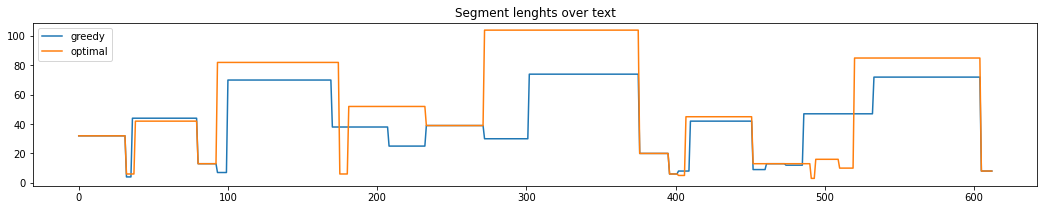

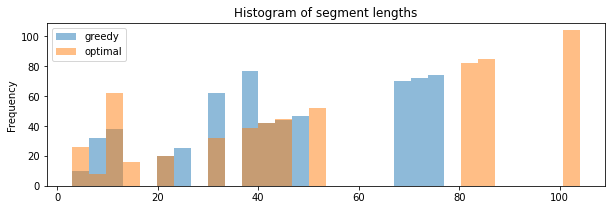

In [49]:
strs = " "
for i in range(len(del_sponsor_sentence)):
  if(del_sponsor_sentence[i] != " "):
    strs =del_sponsor_sentence[i]
  if(i+1<len(del_sponsor_sentence)):
    if(strs == del_sponsor_sentence[i+1]):
      del_sponsor_sentence[i+1]=" "
vecr = CountVectorizer(vocabulary=wrdvecs.index)

sentence_vectors = vecr.transform(del_sponsor_sentence).dot(wrdvecs)
new_length = len(del_sponsor_sentence)**0.6
print(new_length)
penalty = get_penalty([sentence_vectors], new_length)
print('penalty %4.2f' % penalty)

optimal_segmentation = split_optimal(sentence_vectors, penalty, seg_limit=250)
segmented_text = get_segments(del_sponsor_sentence, optimal_segmentation)

print('%d sentences, %d segments, avg %4.2f sentences per segment' % (
    len(del_sponsor_sentence), len(segmented_text), len(del_sponsor_sentence) / len(segmented_text)))

with open(book_path + '.seg', 'wt') as f:
    for i, segment_sentences in enumerate(segmented_text):
        segment_str = ' // '.join(segment_sentences)
        gain = optimal_segmentation.gains[i] if i < len(segmented_text) - 1 else 0
        segment_info = ' [%d sentences, %4.3f] ' % (len(segment_sentences), gain) 
        print(segment_str + '\n8<' + '=' * 30 + segment_info + "=" * 30, file=f)

greedy_segmentation = split_greedy(sentence_vectors, max_splits=len(optimal_segmentation.splits))
greedy_segmented_text = get_segments(del_sponsor_sentence, greedy_segmentation)
lengths_optimal = [len(segment) for segment in segmented_text for sentence in segment]
lengths_greedy = [len(segment) for segment in greedy_segmented_text for sentence in segment]
df = pd.DataFrame({'greedy':lengths_greedy, 'optimal': lengths_optimal})
df.plot.line(figsize=(18, 3), title='Segment lenghts over text')
df.plot.hist(bins=30, alpha=0.5, figsize=(10, 3), title='Histogram of segment lengths')

totals = [get_total(sentence_vectors, seg.splits, penalty) 
          for seg in [optimal_segmentation, greedy_segmentation]]
print('optimal score %4.2f, greedy score %4.2f' % tuple(totals))
print(totals)
print(tuple(totals))
print('ratio of scores %5.4f' % (totals[0] / totals[1]))

In [50]:
for i in range(len(segmented_text)):
  print(segmented_text[i])

['Hi friends. ', "Happy Wednesday or Thursday if you're watching over on YouTube. ", 'Hey, how are you doing? ', "I hope you're having a wonderful day so far. ", 'My name is Bailey. ', 'Sarian. ', 'And this is the dark History podcast on your team song for dark history. ', "Don't I anywho, I'm here to talk about some dark ass history that we never learned in school or I should, at least say that I never learned in school if you're new here. ", 'Hi, welcome, take a seat by me. ', "Don't be shy. ", "If you're interested in learning about people and events that your history books in a covering school and maybe should have then you'll fit in right in here with us. ", 'Ok luck today, story. ', "It's uncomfortable. ", "Okay, it's heartbreaking. ", "It's it's just, it's it's awful. ", "It's that there's, those are all the words I can think of it, just doesn't make any sense. ", "But with all of that being said, there's really like, no sugar-coating this, this is what happened and it's when we

In [51]:
# 將每個段落內的句子合起來變成string
podcast_test = [""]*len(segmented_text)
for i in range(len(segmented_text)):
  for j in range(len(segmented_text[i])):
    podcast_test[i]+=segmented_text[i][j]

In [52]:
headlines = headlineGenerator(podcast_test, min_length, max_length)

Ignoring args : (5, 150)


In [53]:
for headline in headlines:
  print(headline)
  

{'generated_text': 'Dark History Podcast - A Dark History Podcast'}
{'generated_text': 'Rosewood, Florida - A Story of a Hero'}
{'generated_text': 'The Rosewood Massacre'}
{'generated_text': 'Rosewood, Sumner, Sumner, Rosewood, Sumner, Sumner, Sum'}
{'generated_text': 'The Best Fiends - A Game of Screams'}
{'generated_text': 'Jesse Hunter, This is Our Guy.'}
{'generated_text': 'The Black Man That Attacked Fanny'}
{'generated_text': 'Hello Fresh - The Best Meal Kits For the Dark History Posse'}
{'generated_text': 'The Rosewood Massacre'}
{'generated_text': 'The Mob Shot Mingo Williams'}
{'generated_text': "What's a lot of names and Throwing at you?"}
{'generated_text': 'The Rosewood Train Station'}
{'generated_text': 'Squarespace - The Perfect Platform For Your Brand'}
{'generated_text': 'The Rosewood Massacre - No Records'}
{'generated_text': 'The Little Things in Life Are Smiling At Your Neighbor'}
{'generated_text': 'Stamps.com - The Best Way to Save Money and Time'}
{'generated_text

In [54]:
import re
sentence_tokenizer2 = SimpleSentenceTokenizer()
index=0
headlines_string = [""]*len(headlines)
for headline in headlines:
  sentenced_healine = re.split(r'([;,\.\*\n-])',headline['generated_text'])
  #print(sentenced_healine)
  for i in range(len(sentenced_healine)):
    sentenced_healine[i] = sentenced_healine[i].strip()
    #ss = s1
    #print("!!!"+ss+"!!!")
  print(sentenced_healine)
  strs = " "  
  #headlines_string[index]+=sentenced_healine[0]
  for i in range(0,(len(sentenced_healine))):
    if(sentenced_healine[i] != " "):
      strs = sentenced_healine[i]
      for j in range(i+1,(len(sentenced_healine))):
        if(strs == sentenced_healine[j]):
          sentenced_healine[j]=" "
        #if(sentenced_healine[j] != " "):
          #strs = sentenced_healine[j]
  print(sentenced_healine)
  for k in range(len(sentenced_healine)):
    if(sentenced_healine[k] != " "):
      headlines_string[index]+=" "
      headlines_string[index]+=sentenced_healine[k]
  print(type(headlines_string[index]))
  headlines_string[index]=headlines_string[index].rstrip("-")
  index+=1

['Dark History Podcast', '-', 'A Dark History Podcast']
['Dark History Podcast', '-', 'A Dark History Podcast']
<class 'str'>
['Rosewood', ',', 'Florida', '-', 'A Story of a Hero']
['Rosewood', ',', 'Florida', '-', 'A Story of a Hero']
<class 'str'>
['The Rosewood Massacre']
['The Rosewood Massacre']
<class 'str'>
['Rosewood', ',', 'Sumner', ',', 'Sumner', ',', 'Rosewood', ',', 'Sumner', ',', 'Sumner', ',', 'Sum']
['Rosewood', ',', 'Sumner', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', ' ', 'Sum']
<class 'str'>
['The Best Fiends', '-', 'A Game of Screams']
['The Best Fiends', '-', 'A Game of Screams']
<class 'str'>
['Jesse Hunter', ',', 'This is Our Guy', '.', '']
['Jesse Hunter', ',', 'This is Our Guy', '.', '']
<class 'str'>
['The Black Man That Attacked Fanny']
['The Black Man That Attacked Fanny']
<class 'str'>
['Hello Fresh', '-', 'The Best Meal Kits For the Dark History Posse']
['Hello Fresh', '-', 'The Best Meal Kits For the Dark History Posse']
<class 'str'>
['The Rosewood Massacre'

In [55]:
for headline_string in headlines_string:
  print(headline_string)

 Dark History Podcast - A Dark History Podcast
 Rosewood , Florida - A Story of a Hero
 The Rosewood Massacre
 Rosewood , Sumner Sum
 The Best Fiends - A Game of Screams
 Jesse Hunter , This is Our Guy . 
 The Black Man That Attacked Fanny
 Hello Fresh - The Best Meal Kits For the Dark History Posse
 The Rosewood Massacre
 The Mob Shot Mingo Williams
 What's a lot of names and Throwing at you?
 The Rosewood Train Station
 Squarespace - The Perfect Platform For Your Brand
 The Rosewood Massacre - No Records
 The Little Things in Life Are Smiling At Your Neighbor
 Stamps . com - The Best Way to Save Money and Time
 Rosewood , the survivors are living in constant fear
 The Black Community , Not Forgiving
 Rosewood Millionaires , You Know
 The Rosewood Massacre - A History of the Tulsa Race Massacre
 Dark History - Part 2


In [56]:
len(headlines_string)

21

In [57]:
print(headlines_string)
3

[' Dark History Podcast - A Dark History Podcast', ' Rosewood , Florida - A Story of a Hero', ' The Rosewood Massacre', ' Rosewood , Sumner Sum', ' The Best Fiends - A Game of Screams', ' Jesse Hunter , This is Our Guy . ', ' The Black Man That Attacked Fanny', ' Hello Fresh - The Best Meal Kits For the Dark History Posse', ' The Rosewood Massacre', ' The Mob Shot Mingo Williams', " What's a lot of names and Throwing at you?", ' The Rosewood Train Station', ' Squarespace - The Perfect Platform For Your Brand', ' The Rosewood Massacre - No Records', ' The Little Things in Life Are Smiling At Your Neighbor', ' Stamps . com - The Best Way to Save Money and Time', ' Rosewood , the survivors are living in constant fear', ' The Black Community , Not Forgiving', ' Rosewood Millionaires , You Know', ' The Rosewood Massacre - A History of the Tulsa Race Massacre', ' Dark History - Part 2']


3

In [58]:
first_sentence = []
for i in range(len(segmented_text)):
  first_sentence.append(segmented_text[i][0].strip().rstrip().rstrip('.').rstrip('?'))
  print(segmented_text[i][0])
  print(type(segmented_text[i][0]))
  print(len(segmented_text[i]))

Hi friends. 
<class 'str'>
32
For all of that, on the morning of January 1st, 1923 30 year old James, and his 22-year old wife, Fannie, Taylor woke up at a home, and a town called Sumner, a neighboring community of Rosewood. 
<class 'str'>
6
I know because it is. 
<class 'str'>
42
Now, it's a Rosewood. 
<class 'str'>
13
Download the Five star rated puzzle game. 
<class 'str'>
82
I freaking roll-rite, it gets a lot more traumatic talking amongst the name comes up, Jesse Hunter, and they think they're discussing are like, Hey, Jessie Hunter, this is our guy. 
<class 'str'>
6
He must have done. 
<class 'str'>
52
This is just the tip of the iceberg. 
<class 'str'>
39
So the black community is terrified by what they're seeing happening in their own town of Rosewood. 
<class 'str'>
104
Those who could they ran for the swamp? 
<class 'str'>
20
By this time, word got out about what was going on in roast. 
<class 'str'>
6
Okay. 
<class 'str'>
5
Again and a new city. 
<class 'str'>
45
Push back 

In [59]:
print(first_sentence)
print(len((first_sentence)))

['Hi friends', 'For all of that, on the morning of January 1st, 1923 30 year old James, and his 22-year old wife, Fannie, Taylor woke up at a home, and a town called Sumner, a neighboring community of Rosewood', 'I know because it is', "Now, it's a Rosewood", 'Download the Five star rated puzzle game', "I freaking roll-rite, it gets a lot more traumatic talking amongst the name comes up, Jesse Hunter, and they think they're discussing are like, Hey, Jessie Hunter, this is our guy", 'He must have done', 'This is just the tip of the iceberg', "So the black community is terrified by what they're seeing happening in their own town of Rosewood", 'Those who could they ran for the swamp', 'By this time, word got out about what was going on in roast', 'Okay', 'Again and a new city', 'Push back to Stop black people from being excluded, from being chairs', "The only way we're able to tell this story of history is By Word of Mouth", 'Right from your computer, maybe send your grandma letter', "Som